In [18]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import logging

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

## Dimesionality reduction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Machine-learning stack
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier

## Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score
import scipy.stats as stats

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Control Variables

In [19]:
ENABLE = {
    'lgb':    {'cross-val':    0,
               'compute-pauc': 1,
               'final-train':  1,
               'save-model':   0,
              },
}

# Evaluation Functions

In [20]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value

def cross_val_partial_auc_score(X, y, model, n_splits, verbose=1):

     # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    predictions = []
    pauc_scores = []
    cont = 1
   
    for train_idx, val_idx in skf.split(X, y):

        if verbose == 1:
            print(f'Processing fold {cont} of {n_splits}... ', end='', flush=True)
        
        # Create the folds
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                
        # Train the model
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on the validation set
        preds = model.predict_proba(X_val_fold)[:,1]
   
        # Calculate partical AUC and store it
        pauc = partial_auc_score(y_val_fold, preds)
        pauc_scores.append(pauc)

        if verbose == 1:
            print(f'pAUC: {pauc}', flush=True)

        predictions.append((val_idx, preds))
        
        cont = cont + 1

    # Compute the average pauc
    pauc_mean = np.mean(pauc_scores)
    
    # Create the cross-validated CNN feature vector.
    predictions_all = np.zeros(len(X))
    merged_list = []
    
    # Loop over the cancer probability list
    for idx, preds in predictions:
        assert len(idx) == len(preds), "error"
        predictions_all[idx] = preds

    # Return the average
    return pauc_mean, predictions_all

# Model Loading

In [21]:
# Read the metadata-based feature set
#ROOT_DATASET_DIR = "./"
df_meta = pd.read_csv('train-metadata-eda-fe-v3-kaggle.csv')

# Read the image (pixel)-based feature set
df_img_1 = pd.read_csv('train-cnn-crossval-preds-DenseNet121_128_seed1337.csv')
df_img_2 = pd.read_csv('train-cnn-crossval-preds-DenseNet201_128_seed2001.csv')
df_img_3 = pd.read_csv('train-cnn-crossval-preds-EfficientNetB0_128_seed2023.csv')
df_img_4 = pd.read_csv('train-cnn-crossval-preds-InceptionResNetV2_128_seed23.csv')
df_img_5 = pd.read_csv('train-cnn-crossval-preds-InceptionV3_128_seed313.csv')
df_img_6 = pd.read_csv('train-cnn-crossval-preds-NASNetMobile_128_seed1024.csv')
df_img_7 = pd.read_csv('train-cnn-crossval-preds-ResNet152V2_128_seed7.csv')
df_img_8 = pd.read_csv('train-cnn-crossval-preds-Xception_128_seed100.csv')

# Merge with Cross-val CNN Predictions

In [22]:
# Force categorical features to be categorical
df_meta['anatom_site_general'] = pd.Categorical(df_meta['anatom_site_general'])
df_meta['tbp_lv_location'] = pd.Categorical(df_meta['tbp_lv_location'])
df_meta['tbp_lv_location_simple'] = pd.Categorical(df_meta['tbp_lv_location_simple'])
df_meta['sex'] = pd.Categorical(df_meta['sex'])

# Remove the target column in the cross-vall cnn prediction vector
df_img_1.drop(columns=['target'], inplace=True)
df_img_2.drop(columns=['target'], inplace=True)
df_img_3.drop(columns=['target'], inplace=True)
df_img_4.drop(columns=['target'], inplace=True)
df_img_5.drop(columns=['target'], inplace=True)
df_img_6.drop(columns=['target'], inplace=True)
df_img_7.drop(columns=['target'], inplace=True)
df_img_8.drop(columns=['target'], inplace=True)

df_img_1.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_1'}, inplace=True)
df_img_2.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_2'}, inplace=True)
df_img_3.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_3'}, inplace=True)
df_img_4.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_4'}, inplace=True)
df_img_5.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_5'}, inplace=True)
df_img_6.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_6'}, inplace=True)
df_img_7.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_7'}, inplace=True)
df_img_8.rename(columns={'crossval_cnn_preds': 'crossval_cnn_preds_8'}, inplace=True)

# Merge the dataframes and remove 'isic_id'
df_img = pd.merge(df_img_1, df_img_2, on='isic_id', how='left') #inner is also ok
df_img = pd.merge(df_img, df_img_3, on='isic_id', how='left') #inner is also ok
df_img = pd.merge(df_img, df_img_4, on='isic_id', how='left') #inner is also ok
df_img = pd.merge(df_img, df_img_5, on='isic_id', how='left') #inner is also ok
df_img = pd.merge(df_img, df_img_6, on='isic_id', how='left') #inner is also ok
df_img = pd.merge(df_img, df_img_7, on='isic_id', how='left') #inner is also ok
df_img = pd.merge(df_img, df_img_8, on='isic_id', how='left') #inner is also ok

# Compute the min_sqrt feature
cnn_predictions = df_img.drop(columns=['isic_id']).values
df_min_sqrt = pd.DataFrame({'crossval_cnn_preds_min_sqrt': np.sqrt(np.min(cnn_predictions, axis=1))})

# Concatenate with df
df_img_stats = pd.concat([df_img, df_min_sqrt], axis=1)
df = pd.merge(df_meta, df_img_stats, on='isic_id', how='left')
df_img_stats.drop(columns=['isic_id'], inplace=True)
df_img.drop(columns=['isic_id'], inplace=True)
df.drop(columns=['isic_id'], inplace=True)

# Preparing Feature Dataset and Targets

In [23]:
# Train-Test split
# Drop non-used features for the baseline + target
X = df.drop(['target']      
            ,
             axis=1)
y = df['target']

In [24]:
cnn_features = df_img.columns.tolist()
min_sqrt_feature = df_min_sqrt.columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
numerical_features = [x for x in numerical_features if x not in cnn_features + min_sqrt_feature]
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features} - Length: {len(numerical_features)}")
print(f"Categorical features: {categorical_features} - Length: {len(categorical_features)}")

Numerical features: ['age_approx', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', 'position_distance_3d', 'log_perimeter_to_area_ratio', 'area_to_perimeter_ratio', 'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 'color_consistency', 'consistency_colo

# Dimensionality Reduction Analysis

In [25]:
def apply_kbest(X, y, threshold):

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=['float64','int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['category']).columns.tolist()
    
    # Use SelectKBest (f_classif) for numerical features
    Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
    Kbest_numerical.fit(X[numerical_features], y)
    
    # Extract feature scores and p-values
    scores = Kbest_numerical.scores_
    pvalues = Kbest_numerical.pvalues_
    
    # Create a DataFrame to save feature names, scores, and p-values
    feature_scores = pd.DataFrame({
        'Feature': numerical_features,
        'Score': scores,
        'P-Value': pvalues
    })
    
    # Sort features by 'Score'
    best_feature_scores = feature_scores[feature_scores['P-Value'] < threshold]
    sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)
    
    # Display the sorted features
    kbest_num = sorted_features.shape[0]
    print(f"Number of relevant numerical features: {kbest_num}\n")
    print(sorted_features.set_index('Feature'))
    
    #best_numerical_features = sorted_features.index.tolist()
    
    # Plot feature importance
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot()
    sns.barplot(x='Feature', y='Score', data=sorted_features, ax=ax)
    plt.xticks(rotation=90, ha='right')
    plt.title('Feature Importance - Numerical', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Importance', fontsize=14)
    #plt.tight_layout()
    plt.show()
    
    # Use SelectKBest (chi2) for categorical features

    # Build a pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
        ],
        remainder='drop'
    )
    
    pipeline = Pipeline(steps=[
        ('onehot', preprocessor),
        ('kbest', SelectKBest(score_func=chi2, k='all'))
    ])
    
    cat_transformed = pipeline.fit_transform(X, y)
    Kbest_categorical = pipeline.named_steps['kbest']
    
    # Extract feature scores and p-values
    scores = Kbest_categorical.scores_
    pvalues = Kbest_categorical.pvalues_
    
    # Extract feature names after one-hot encoding
    one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)
    
    # Create a DataFrame to hold feature names, scores, and p-values
    feature_scores = pd.DataFrame({
        'Feature': one_hot_feature_names,
        'Score': scores,
        'P-Value': pvalues
    })
    
    # Sort features by their scores
    best_feature_scores = feature_scores[feature_scores['P-Value'] < threshold]
    sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)
    
    # Display the sorted features
    kbest_cat = sorted_features.shape[0]
    print(f"Number of relevant categorical features: {kbest_cat}\n")
    print(sorted_features.set_index('Feature'))

     # Plot feature importance
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot()
    sns.barplot(x='Feature', y='Score', data=sorted_features, ax=ax)
    plt.xticks(rotation=90, ha='right')
    plt.title('Feature Importance - Categorical', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Importance', fontsize=14)
    #plt.tight_layout()
    plt.show()
    
    #best_categorical_features = sorted_features.index.tolist()
    
    return kbest_num, kbest_cat

    #best_features = best_numerical_features + best_categorical_features

Number of relevant numerical features: 86

                                   Score   P-Value
Feature                                           
crossval_cnn_preds_min_sqrt  9718.037241  0.000000
crossval_cnn_preds_2         4806.596226  0.000000
crossval_cnn_preds_1         4525.345862  0.000000
crossval_cnn_preds_5         4517.123807  0.000000
crossval_cnn_preds_7         4249.804306  0.000000
...                                  ...       ...
texture_uniformity              8.768705  0.003065
border_density                  7.883024  0.004990
area_diameter_ratio             7.833223  0.005130
tbp_lv_L                        6.699025  0.009647
3d_position_angle_xz            4.017118  0.045041

[86 rows x 2 columns]


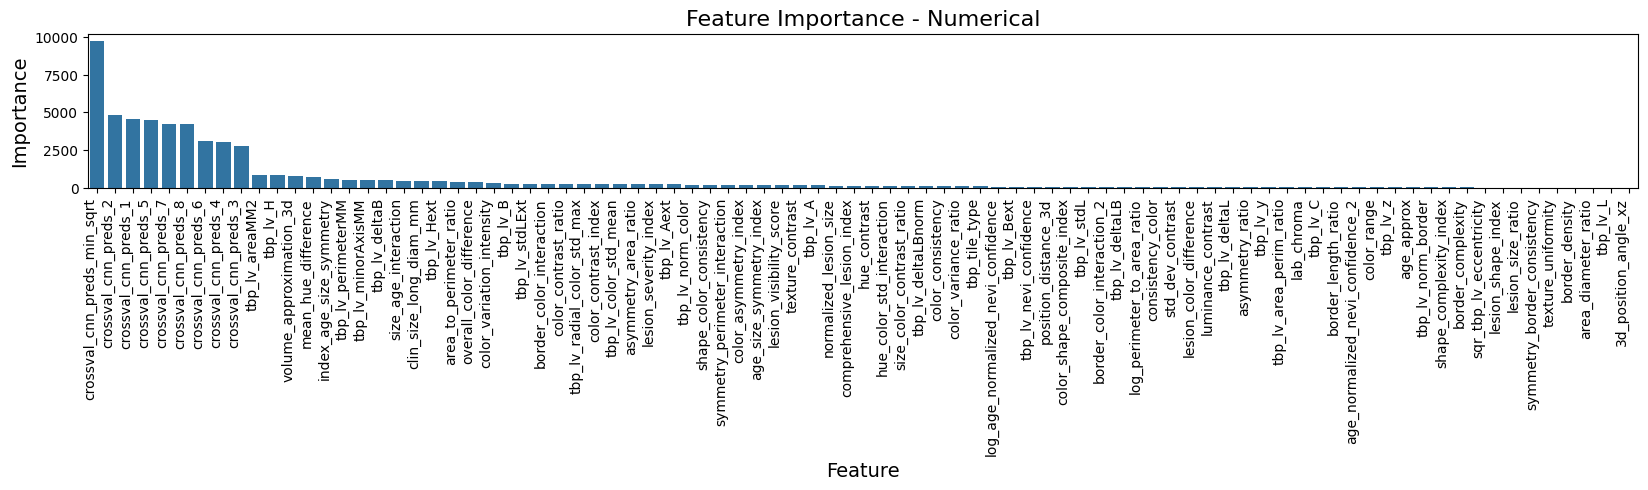

Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                          
anatom_site_general_head/neck            364.361682  3.161229e-81
tbp_lv_location_Right Leg - Upper         15.614025  7.767632e-05
tbp_lv_location_simple_Right Leg           8.605018  3.352381e-03
anatom_site_general_lower extremity        8.463089  3.624258e-03
tbp_lv_location_Left Leg                   8.314718  3.932510e-03
tbp_lv_location_Torso Front Bottom Half    5.201509  2.256728e-02
tbp_lv_location_Torso Back Middle Third    4.221756  3.990885e-02
tbp_lv_location_Left Leg - Upper           3.866920  4.924681e-02


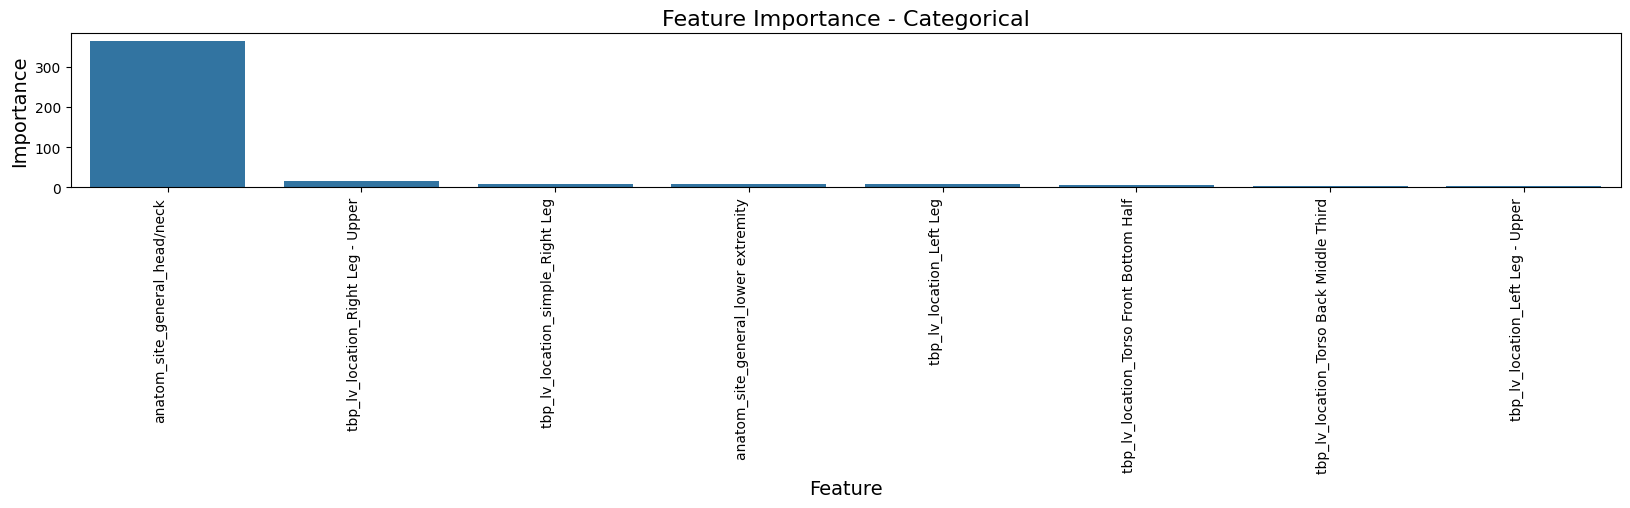

In [26]:
KBEST_NUM, KBEST_CAT = apply_kbest(X, y, 0.05)

# Preprocessing Pipeline 

In [27]:
# Pipeline
from sklearn.preprocessing import FunctionTransformer

pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ###('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)), # From KBest   
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ###('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)), # From KBest
])

preprocessing = ColumnTransformer(transformers=[
    ('cnn_preds + min_sqrt', 'passthrough', cnn_features + min_sqrt_feature),
    ('numerical_meta', pipe_num, numerical_features),
    ('categorical_meta',pipe_cat, categorical_features)
])

In [28]:
preprocessing

ColumnTransformer(transformers=[('cnn_preds + min_sqrt', 'passthrough',
                                 ['crossval_cnn_preds_1',
                                  'crossval_cnn_preds_2',
                                  'crossval_cnn_preds_3',
                                  'crossval_cnn_preds_4',
                                  'crossval_cnn_preds_5',
                                  'crossval_cnn_preds_6',
                                  'crossval_cnn_preds_7',
                                  'crossval_cnn_preds_8',
                                  'crossval_cnn_preds_min_sqrt']),
                                ('numerical_meta',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['a...
                                  'tbp_lv_nevi_confidence',
                                  'tbp_lv_norm_border', 'tbp_lv_norm_color',
                                  'tbp_lv_perimeterMM',
                                  'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
                                  'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', ...]),
                                ('categorical_meta',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'anatom_site_general',
                                  'tbp_lv_location',
                                  'tbp_lv_location_simple'])])

# LightGBM

### Cross-validation

In [29]:
if ENABLE['lgb']['cross-val'] == 1:
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        
        # Suggest values for the hyperparameters
        random_state = 42
        verbosity = -1
        objective = 'binary'
        boosting_type = 'gbdt'
        n_estimators = trial.suggest_int('n_estimators', 400, 1000) #100, 500)    
        lambda_l1 = trial.suggest_float('lambda_l1', 0.001, 0.1)
        lambda_l2 = trial.suggest_float('lambda_l2', 0.001, 0.1)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0)
        max_depth = trial.suggest_int('max_depth', 20, 50)    
        num_leaves = trial.suggest_int('num_leaves', 2, 200) #100)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
        colsample_bynode = trial.suggest_float('colsample_bynode', 0.1, 1.0)
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0) 
        bagging_freq = trial.suggest_int('bagging_freq', 0, 15)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 10)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)
    
        pauc_scores = []
    
        for train_idx, val_idx in skf.split(X, y):

            # Create the folds
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                        
            # Pipeline
            pipe_lgb = ImbPipeline([
                ('preprocessing', preprocessing),
                ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
                ('oversample', SMOTE(sampling_strategy={1: 8000}, random_state=42)),
                ('LGB', LGBMClassifier(random_state=random_state,
                                       verbosity=verbosity,
                                       objective=objective,
                                       boosting_type=boosting_type,                                   
                                       n_estimators=n_estimators,
                                       lambda_l1=lambda_l1,
                                       lambda_l2=lambda_l2,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       num_leaves=num_leaves,
                                       colsample_bytree=colsample_bytree,
                                       colsample_bynode=colsample_bynode,
                                       bagging_fraction=bagging_fraction,
                                       bagging_freq=bagging_freq,
                                       min_data_in_leaf=min_data_in_leaf,
                                       scale_pos_weight=scale_pos_weight
                                      )         
                )
            ])
    
            # Train the model
            pipe_lgb.fit(X_train_fold, y_train_fold)
        
            # Predict on the validation set
            preds = pipe_lgb.predict_proba(X_val_fold)[:,1]
        
            # Calculate partical AUC and store it
            pauc = partial_auc_score(y_val_fold, preds)
            pauc_scores.append(pauc)
        
        # Return the average
        return np.mean(pauc_scores)
    
    # Create a study object with 'maximize' direction
    study = optuna.create_study(direction='maximize')
    
    # Start the optimization
    study.optimize(objective, n_trials=2000, n_jobs=-1)
    
    # Get the best trial
    best_trial = study.best_trial
    
    print(f'Best trial number: {best_trial.number}')
    print(f'Best value (partial auc - 0.8): {best_trial.value}')
    print(f'Best hyperparameters: {best_trial.params}')

Trial 808 finished with value: 0.16979714168868304 and parameters: {'n_estimators': 673, 'lambda_l1': 0.08413324017507645, 'lambda_l2': 0.06428061632619714, 'learning_rate': 0.005356069417792279, 'max_depth': 34, 'num_leaves': 143, 'colsample_bytree': 0.16975539723374256, 'colsample_bynode': 0.7025397530081993, 'bagging_fraction': 0.27489317689929416, 'bagging_freq': 7, 'min_data_in_leaf': 6, 'scale_pos_weight': 1.7052090178271815}. Best is trial 808 with value: 0.16979714168868304.

Trial 1495 finished with value: 0.16985261445730085 and parameters: {'n_estimators': 685, 'lambda_l1': 0.08948450633089927, 'lambda_l2': 0.04720518517747972, 'learning_rate': 0.006556272682897957, 'max_depth': 21, 'num_leaves': 100, 'colsample_bytree': 0.13923083569102723, 'colsample_bynode': 0.7158919417379254, 'bagging_fraction': 0.1978311121993066, 'bagging_freq': 5, 'min_data_in_leaf': 6, 'scale_pos_weight': 1.494168377018992}. Best is trial 1495 with value: 0.16985261445730085.

### Cross-validation Partial AUC Score

In [30]:
# Parameters
param_lgb_1 = {
    'random_state':     42,
    'objective':        'binary',
    'boosting_type':    'gbdt',
    'verbosity':        -1,
    'n_estimators':     685,
    'lambda_l1':        0.08948450633089927,
    'lambda_l2':        0.04720518517747972,
    'learning_rate':    0.006556272682897957,
    'max_depth':        21,
    'num_leaves':       100,
    'colsample_bytree': 0.13923083569102723,
    'colsample_bynode': 0.7158919417379254,
    'bagging_fraction': 0.1978311121993066,
    'bagging_freq':     5,
    'min_data_in_leaf': 6,
    'scale_pos_weight': 1.494168377018992
}

# Model pipeline
model_lgb_1 = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 8000}, random_state=42)),
        ('LGB_1',  LGBMClassifier(**param_lgb_1))
])

# Cross-validation partial AUC score and prediction vector
if ENABLE['lgb']['compute-pauc'] == 1:

    # Cross-validation partial AUC score
    pauc_lgb_cv, pred_vector_cv = cross_val_partial_auc_score(X, y, model_lgb_1, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_lgb_cv}")

    # Cross-validation LGB prediction vector
    df_isic_id = df_meta[['isic_id']]
    df_target = df_meta[['target']]
    df_lgb = pd.DataFrame({'crossval_lgb_preds': pred_vector_cv.flatten()})
    df_lgb = pd.concat([df_isic_id, df_lgb, df_target], axis=1)
    df_lgb.to_csv(f"train-cnn-crossval-preds-lgb_v3.csv", index=False)

Processing fold 1 of 5... pAUC: 0.16150698011948883
Processing fold 2 of 5... pAUC: 0.17586057903274863
Processing fold 3 of 5... pAUC: 0.17104134286004596
Processing fold 4 of 5... pAUC: 0.1711488953341527
Processing fold 5 of 5... pAUC: 0.1697593219876778
CV Partial AUC Score: 0.1698634238668228


In [31]:
model_lgb_1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cnn_preds + min_sqrt',
                                                  'passthrough',
                                                  ['crossval_cnn_preds_1',
                                                   'crossval_cnn_preds_2',
                                                   'crossval_cnn_preds_3',
                                                   'crossval_cnn_preds_4',
                                                   'crossval_cnn_preds_5',
                                                   'crossval_cnn_preds_6',
                                                   'crossval_cnn_preds_7',
                                                   'crossval_cnn_preds_8',
                                                   'crossval_cnn_preds_min_sqrt']),
                                                 ('numerical_meta',
                                                  Pipeline(steps...
                 LGBMClassifier(bagging_fraction=0.1978311121993066,
                                bagging_freq=5,
                                colsample_bynode=0.7158919417379254,
                                colsample_bytree=0.13923083569102723,
                                lambda_l1=0.08948450633089927,
                                lambda_l2=0.04720518517747972,
                                learning_rate=0.006556272682897957,
                                max_depth=21, min_data_in_leaf=6,
                                n_estimators=685, num_leaves=100,
                                objective='binary', random_state=42,
                                scale_pos_weight=1.494168377018992,
                                verbosity=-1))])

### Final Training

In [32]:
def plot_feature_importance(importances, feature_names):
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # Plot feature importance
    fig = plt.figure(figsize=(10,30))
    ax = fig.add_subplot()
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()

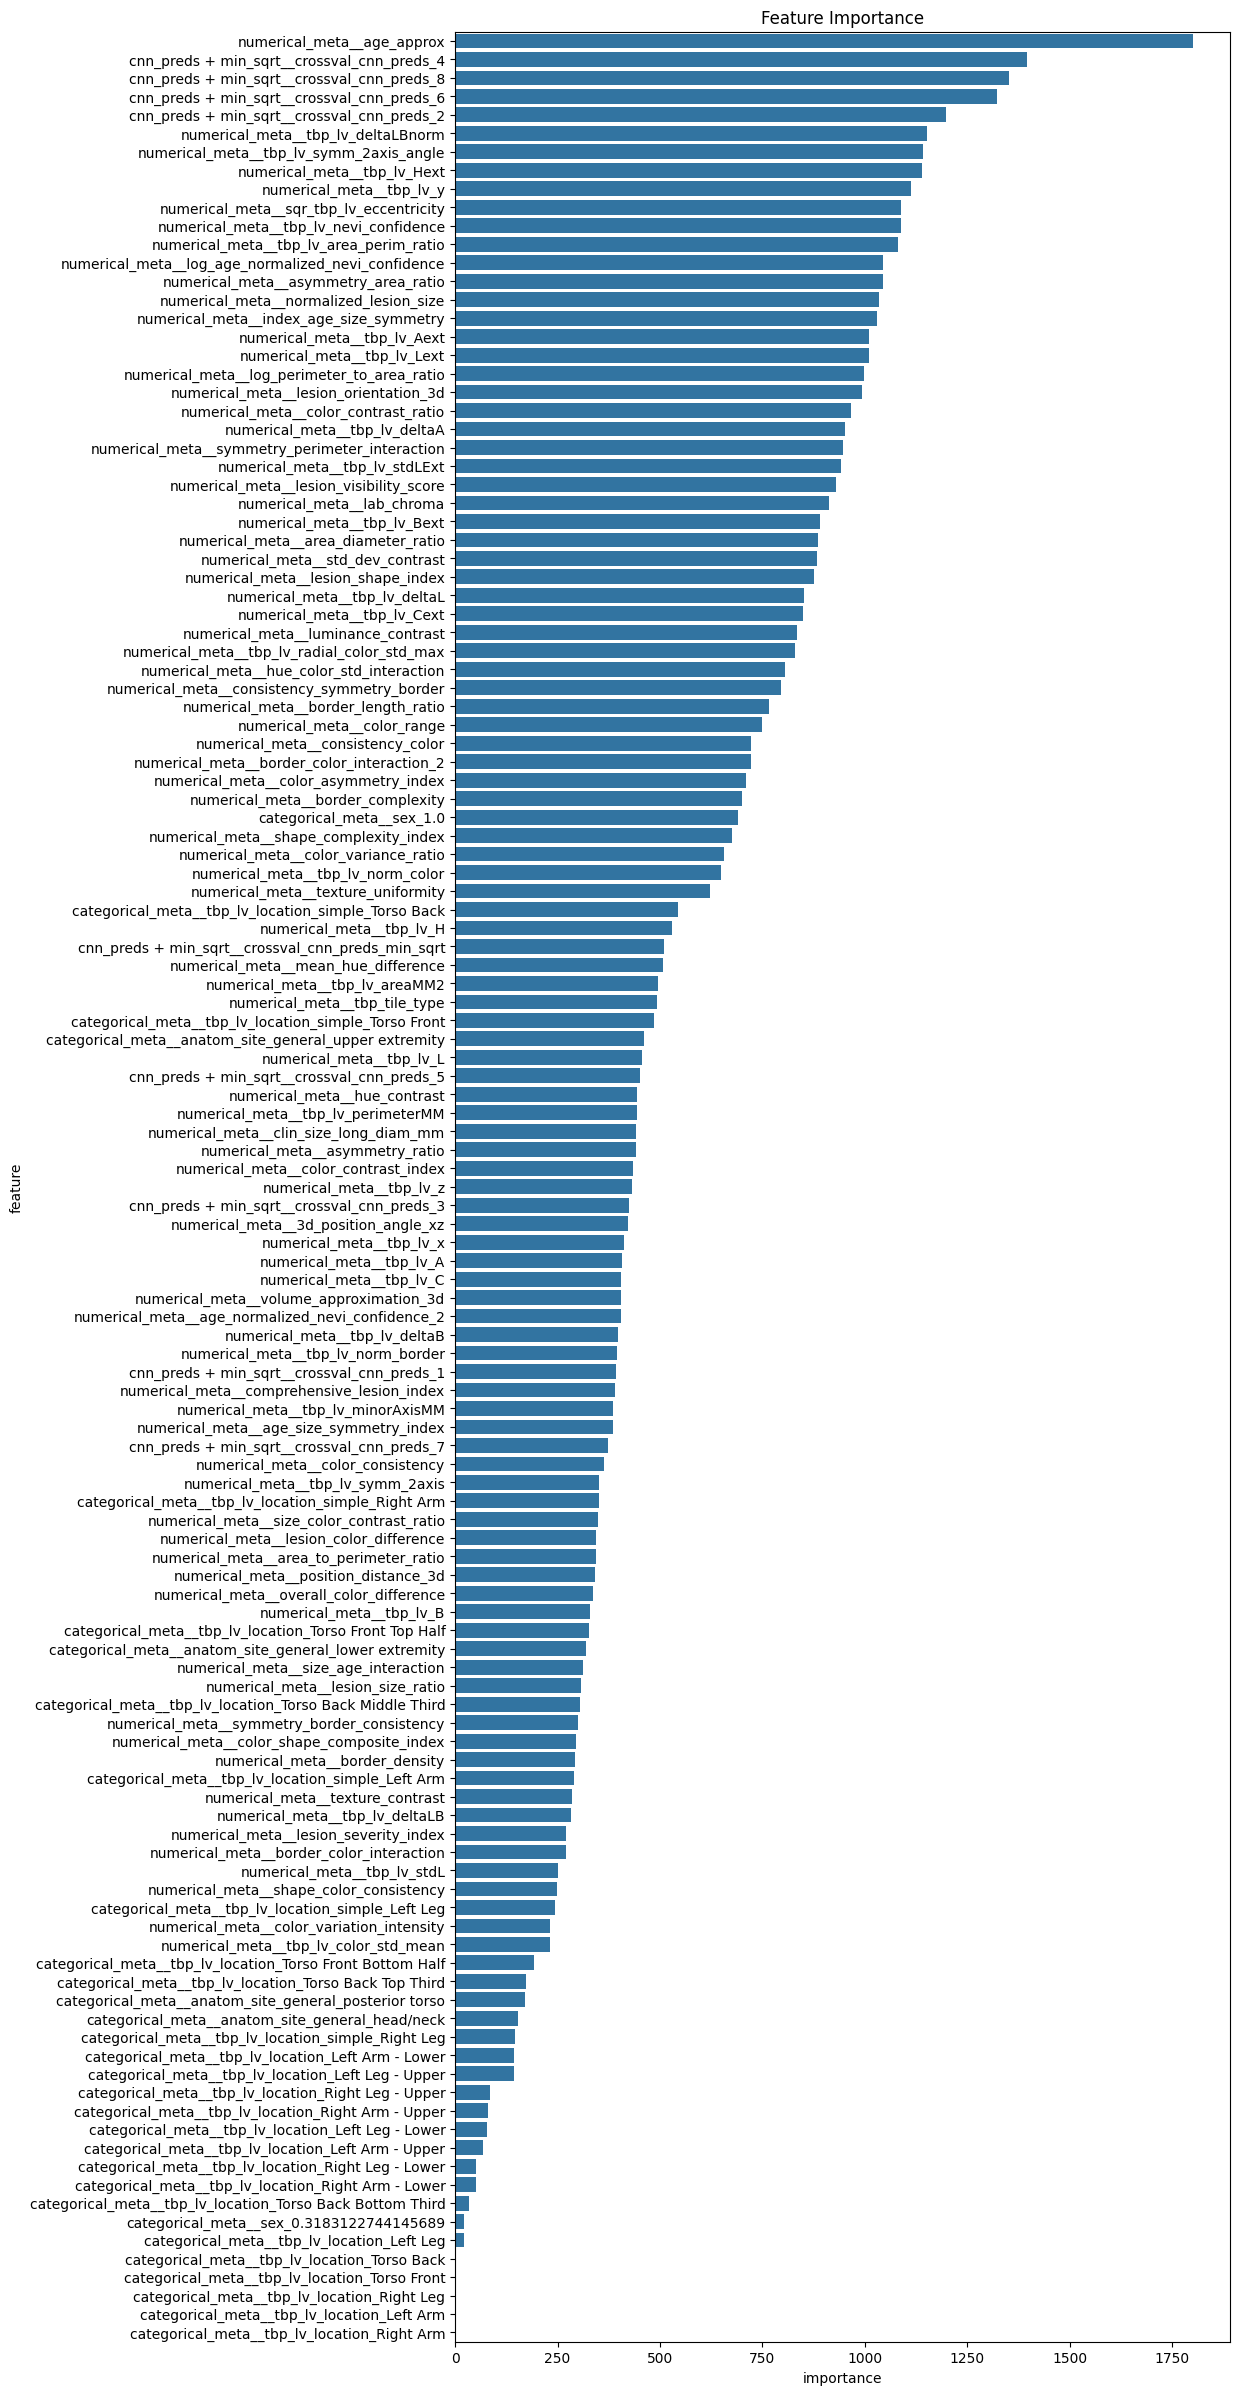

In [33]:
if ENABLE['lgb']['final-train'] == 1:
    
    # Fit with the whole dataset
    model_lgb_1.fit(X, y)

    # Feature importance analysis
    importances = model_lgb_1.named_steps['LGB_1'].feature_importances_
    feature_names = model_lgb_1.named_steps.preprocessing.get_feature_names_out()
    plot_feature_importance(importances, feature_names)

### Model Saving

In [34]:
if ENABLE['lgb']['save-model'] == 1:
    dump(model_lgb, 'model_lgb_1.pkl')